# 07 PyTorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiments are worth persuing, that's where experiment tracking comes in, it helps you to figure out what doesn't work and what does work.

In this notebook, we're going to see an example of programatically tracking experiments.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.0
0.14.0


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0
torchvision version: 0.14.0


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get data

Want to get pizza, steak, sushi image.

So we can run experiments building FodVision Mini  and see which model performs best.

In [6]:
import os 
import zipfile
import requests
from pathlib import Path

def download_data(source:str,
                 destination: str,
                 remove_source: bool=True) -> Path:
    
    """Downloads a zipped dataset from source and unzips to destination"""
    #  setup path to the data folder
    data_path = Path("data")
    image_path = data_path / destination
    
    # If the image folder doesn't exist, create it
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, skipping download.")
    else:
            print(f"[INFO] Did not find {image_path} directory, creating one...")
            image_path.mkdir(parents=True, exist_ok=True)
            
            # Download the target data 
            target_file = Path(source).name
            with open(data_path / target_file, "wb") as f:
                request = requests.get(source)
                print(f"[INFO] Downloading {target_file} from {source}...")
                f.write(request.content)
                
                
            # Unzip file
            with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
                print(f"(INFO) Unzipping {target_file} data...")
                zip_ref.extractall(image_path)
                
            # Remove .zip file if needed
            if remove_source:
                os.remove(data_path/ target_file)
    return image_path

In [7]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory already exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1 Create Datasets with manual transforms
The goal with transforms is to ensure your custom data is formatted in a reproducible way as well as a way that suit pretrained models.

In [8]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [9]:
# Setup ImageNet normalization levels

from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transfrom pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                  test_dir=test_dir,
                                                                  transform=manual_transforms,
                                                                  batch_size=32)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x2ab8cd27940>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transfroms

The same principle applies for automatic transforms: we want our custom data int the same format as a pretrained model was trained on.

In [10]:
# Setup dirs
train_dir = image_path / "train"
test = image_path / "test"

# Setup pretrained weights (plenty of weights available in torchvision.models v0.13+)
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

#  Get transforms for weights.
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=automatic_transforms,
                                                                                batch_size=32)


train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x2ab8aba13f0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [11]:
# Download the pretrained weights for EfficientNet_B0_
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = best availabel weights

# Setup the model with the pretrained weights and send it to the target device
model= torchvision.models.efficientnet_b0(weights=weights).to(device)

# Get the summary of the model
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Trainable
EfficientNet                                            [1, 3, 224, 224]          True
├─Sequential: 1-1                                       [1, 3, 224, 224]          True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]         True
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112]         True
│    └─Sequential: 2-3                                  [1, 16, 112, 112]         True
│    │    └─MBConv: 3-5                                 [1, 16, 112, 112]         True
│    │    └─MBConv: 3-6                 

In [12]:
# Freeze all the base layers by setting their requires_grad attribute to False
for params in model.features.parameters():
    params.requires_grad = False

In [13]:
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Trainable
EfficientNet                                            [1, 3, 224, 224]          Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]         False
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112]         False
│    └─Sequential: 2-3                                  [1, 16, 112, 112]         False
│    │    └─MBConv: 3-5                                 [1, 16, 112, 112]         False
│    │    └─MBConv: 3-6      

In [14]:
# Change the classifier head
from torch import nn
set_seeds()

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1280,
              out_features=len(class_names)).to(device)
)

In [15]:
from torchinfo import summary

summary(model,
        input_size=(1, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train a single model and track the results

In [16]:
# Define a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

To Interact with tensorboard we will use PyTorch's `SummaryWriter()`

In [17]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [18]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

# Import train() function from:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()

    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [19]:
model_results = train(model=model,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=5,
                         device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0563 | train_acc: 0.4961 | test_loss: 0.9179 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.9619 | train_acc: 0.5469 | test_loss: 0.8445 | test_acc: 0.6316
Epoch: 3 | train_loss: 0.8343 | train_acc: 0.6797 | test_loss: 0.7426 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7484 | train_acc: 0.6953 | test_loss: 0.6376 | test_acc: 0.8551
Epoch: 5 | train_loss: 0.7032 | train_acc: 0.7227 | test_loss: 0.6244 | test_acc: 0.8759


In [20]:
model_results

{'train_loss': [1.056260921061039,
  0.9618565142154694,
  0.8342530652880669,
  0.7484009340405464,
  0.7031850144267082],
 'train_acc': [0.49609375, 0.546875, 0.6796875, 0.6953125, 0.72265625],
 'test_loss': [0.9178873896598816,
  0.8444862763086954,
  0.7426096200942993,
  0.637571116288503,
  0.6244051853815714],
 'test_acc': [0.5909090909090909,
  0.631628787878788,
  0.8560606060606061,
  0.8551136363636364,
  0.8759469696969697]}


## 5. View our model's results in TensorBoard

## 6. Create a helper function to build SummaryWriter() instances

In [21]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None)-> torch.utils.tensorboard.writer.SummaryWriter():
  from datetime import datetime
  import os
  
  # Get time stamp of the current data
  timestamp = datetime.now().strftime("%Y-%m-%d") 
  
  if extra: 
    # Create log_dir
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    
  else:
    log_dir = os.path.join(log_dir, timestamp, experiment_name, model_name)
    
  print(f"[INFO] SummaryWriter created saving to {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [22]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] SummaryWriter created saving to runs\2022-12-03\data_10_percent\effnetb0\5_epochs


## 6.1 Update the train() function to include a writer parameter

In [23]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling parameters

It's to step things up a notch.
Previously we've been running various experiments and inspecting the results one by one.
but what if we could run multiple experiments and inspect the results all together?


### 7.1 What kind of experiments you should run?
That's the million dollar question in machine learning.
Because there's really no limit to the experiments you can urn.
Such a freedom is why machine learning is so exciting and terrifying at the same time.

Every hyperparameter stands as s starting point for a different experiment.
* Change the number of **epochs**
* Change the number of **layers/hidden_units**
* Change the amount of **data**
* Change the **learning_rate**
* Try different kinds of **data_augmentation**
* Choose the different **model architecture**

### 7.2 What experiments are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of test set accuracy (90%+) but doesn't take too long to train/perform inference (make predictions).

We've got plenty of options but how about we keep things simple?

Let's try a combination of:

1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
3. A different training time (5 epochs vs. 10 epochs)

1.	         Pizza, Steak, Sushi 10% percent data 	EfficientNetB0 model	5
2.	         Pizza, Steak, Sushi 10% percent data	EfficientNetB2 model	5
3.	         Pizza, Steak, Sushi 10% percent data	EfficientNetB0 model	10
4.	         Pizza, Steak, Sushi 10% percent data	EfficientNetB2 model	10
5.          Pizza, Steak, Sushi 20% percent data	EfficientNetB0 model	5
6.	         Pizza, Steak, Sushi 20% percent data	EfficientNetB2 model	5
7.          Pizza, Steak, Sushi 20% percent data	Efficient modelNetB0 model	10
8.	         Pizza, Steak, Sushi 20% percent data	EfficientNetB2 model	10

### 7.3 Download different datasets

We will need two forms of training set:
1. A training set with **10% of the data** of Food101 pizza, steak, sushi images.
2. A training set  with **20% fo the data** of Food101 pizza, steak, sushi images

In [24]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory already exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory already exists, skipping download.


In [25]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_10_percent}")
print(f"Testing directory; {test_dir}")


Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi\train
Testing directory; data\pizza_steak_sushi\test


### 7.4 Transform datasets and create dataloaders

Now we'll create a series of transforms to prepare our images for our model.

We manually create a transform and use the transform for all the datasets.

The transform will consist of :
1. Resize the images (we'll start with 224, 224 but this could be changed.)
2. Turn them into tensors with values between 0 and 1.
3. Normalize them in a way so their distributions are inline with the ImageNet dataset.


In [26]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

# Check our our transform layer
simple_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [27]:
from going_modular.data_setup import create_dataloaders
# Convert our data into dataloaders
BATCH_SIZE=32

# Create DataLoaders for 10% percent data
train_dataloader_10_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_10_percent,
                                                                  test_dir=test_dir,
                                                                  transform=simple_transform,
                                                                  batch_size=BATCH_SIZE)

# Create DataLoaders for 20% data
train_dataloader_20_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_20_percent,
                                                                  test_dir=test_dir,
                                                                  transform=simple_transform,
                                                                  batch_size=BATCH_SIZE)

# Check out the dataloaders
print(f"Number of batches of size {BATCH_SIZE} in train data 10 percent: {len(train_dataloader_10_percent)}")
print(f"Numer of batches of size {BATCH_SIZE} in train data 20 percent: {len(train_dataloader_20_percent)}")
print(F"Number of batches of size {BATCH_SIZE} in test data: {len(test_dataloader)}")
print(f"Number of class names: {len(class_names)} class names: {class_names}")

Number of batches of size 32 in train data 10 percent: 8
Numer of batches of size 32 in train data 20 percent: 15
Number of batches of size 32 in test data: 3
Number of class names: 3 class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

Time to start building our models.

We're going to create two feature extractor models:

* `torchvision.models.efficientnet_b0()` pretrained backbone + custom classifier head (EffNetB0 for short).
* `torchvision.models.efficientnet_b2()` pretrained backbone + custom classifier head (EffNetB2 for short).

In [28]:
import torch
from torch import nn
from torchinfo import summary

# Create an instance of EfficientNetB0
effnet_b0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnet_b0  = torchvision.models.efficientnet_b0(weights = effnet_b0_weights).to(device)

# Freeze all the layers
for params in effnet_b0.features.parameters():
    params.requires_grad = False

# Get the summary of the model
summary(effnet_b0, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [29]:
# Create a custom classifier head
effnet_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1280,
              out_features=len(class_names)).to(device)
)

# Get the summary of the model again
summary(effnet_b0, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [30]:
# Create effnet_b2 model and freeze the layers
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_b2 = torchvision.models.efficientnet_b2(weights=effnet_b2_weights).to(device)

# Get the summary of the model
summary(effnet_b2, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [31]:
# Freeze the layers and make a custom classifier head
for params in effnet_b2.features.parameters():
    params.requires_grad = False

# Make a custom classifier head
effnet_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1408,
              out_features=len(class_names)).to(device)
)

# Get the summary of the model again
summary(effnet_b2, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

### Functionize the above steps


In [32]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [33]:
# Create a EffNetB0 
effnetb0 = create_effnetb0()

# Create a EffNetb2
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


## 7.5 Create experiments and setup 

We've prepared our data and prepared our models, the time has come to setup some experiments!

We'll start by creating two lists and a dictionary:

* A list of the number of epochs we'd like to test (`[5, 10]`)
* A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
* A dictionary of the different training DataLoaders

Lists and dictionary created!

Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps:

* Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
* Keep track of different experiment numbers (this is mostly for pretty print outs).
* Loop through the train_dataloaders dictionary items for each of the different training DataLoaders.
* Loop through the list of epoch numbers.
* Loop through the list of different model names.
* Create information print outs for the current running experiment (so we know what's happening).
* Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
* Create a new loss function (torch.nn.CrossEntropyLoss()) and optimizer (torch.optim.Adam(params=model.parameters(), lr=0.001)) for each new experiment.
* Train the model with the modified train() function passing the appropriate details to the writer parameter.
* Save the trained model with an appropriate file name to file with save_model() from utils.py.
We can also use the %%time magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

In [34]:
# 1. Create epoch list
num_epochs = [5, 10]

# 2. Create models list
models = ["effnetb0", "effnetb2"]

# 3. Create various dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}


In [38]:
from going_modular.utils import save_model

# Set the random seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    
    # Loop through the epochs
    for epochs in num_epochs:
        for model_name in models:
            # Create information printouts
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Dataloader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")
            
            # 7. Select the model
            if model_name == "effnet_b0":
                model = create_effnetb0()
                
            else: 
                model = create_effnetb2()
            
            # Create a new loss function and  optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Train experiment with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Dataloader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] SummaryWriter created saving to runs\2022-12-03\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3828 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7086 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] Dataloader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] SummaryWriter created saving to runs\2022-12-03\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3828 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7086 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] Dataloader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] SummaryWriter created saving to runs\2022-12-03\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3828 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7086 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6331 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6400 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6200 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6232 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4918 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10.pth
-------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3828 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7086 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6331 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6400 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6200 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6232 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4918 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10.pth
-------------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7774 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7297 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8479 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5684 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4469 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] Dataloader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] SummaryWriter created saving to runs\2022-12-03\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7774 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7297 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8479 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5684 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4469 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] Dataloader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] SummaryWriter created saving to runs\2022-12-03\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7774 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7297 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8479 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5684 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4469 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9146 | test_loss: 0.4564 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4226 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8979 | test_loss: 0.3908 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10.pth
-------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7774 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7297 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8479 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5684 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4469 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9146 | test_loss: 0.4564 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4226 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8979 | test_loss: 0.3908 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10.pth
-------------------------------------------

## 8. View experiments in TensoBoard

How about we  check out the result in TensorBoard

In [39]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

You can upload your experiments in TensorBoard.deb

In [40]:
# # Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."

## 9. Load in the best model and make prediction with it

It seems experiment 8 acheived the best overall results (high test accuracy, lowest second test loss)

This is the experiment that we used.
* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 10 epochs (double the original training time)

In [42]:
# Import our best performing model

# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10.pth"

# Instantiate a new instance of EffNetB2
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [43]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


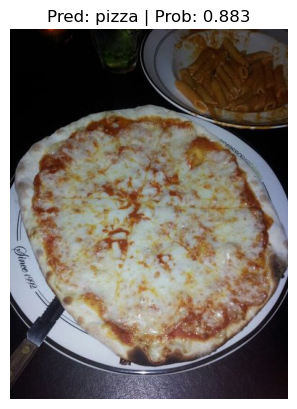

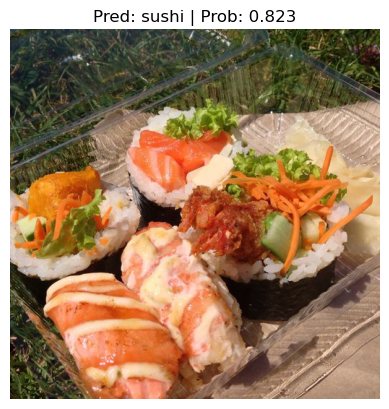

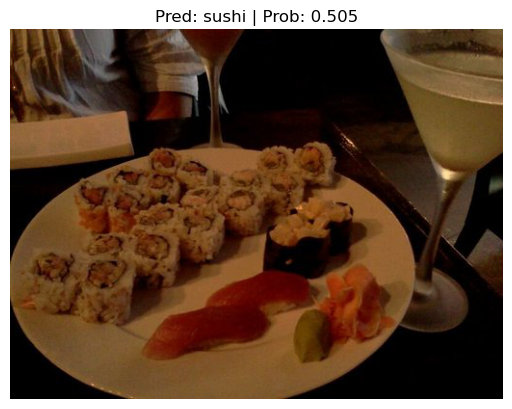

In [46]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### 9.1 Predict on a custom image with the best model


data\04-pizza-dad.jpeg already exists, skipping download.


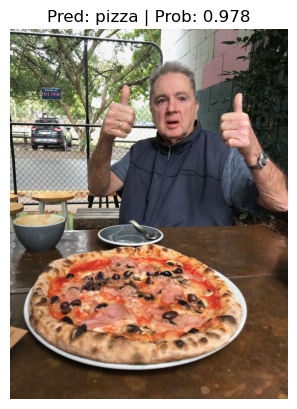

In [47]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)